## Task 5.2 Second Attempt:

We present a neural network to train on the combned data (PCA from both accelerometer and depth camera)

Run task **five** first to get training and testing features (from Task 5.2 attempt 2, notebook slovo_five)
If you have run task one yourself before you can skip first cell bellow

In [ ]:
%%capture
%run ./slovo_five.ipynb

In [34]:
#Save for use in other notebooks - get data from 5.2 try 2:
%store -r act_features
%store -r act_test_features
%store -r labels_train
%store -r labels_test
%store -r dc_features
%store -r dc_test_features

act_features = act_features
act_test_features = act_test_features
labels_train = labels_train -1
labels_test  = labels_test - 1
dc_features = dc_features
dc_test_features = dc_test_features

In [35]:
# import necessary packages
import os
import random
import torch
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [36]:
combined_features = np.concatenate((act_features,dc_features),axis=1)
combined_test_features = np.concatenate((act_test_features,dc_test_features),axis=1)

In [37]:
# write the customer dataset based on the dataset
class ADataset(Dataset):
    """Fashion Mnist dataset"""

    def __init__(self, data, labels):
        self.data = torch.tensor(data)#.cuda()
        self.labels = torch.tensor(labels)#.cuda()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        record, label = self.data[index], self.labels[index]
        return record, label


g = torch.Generator()
g.manual_seed(0)

train_set = ADataset(combined_features,labels_train)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4,generator=g)
test_set = ADataset(combined_test_features,labels_test)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4,generator=g)

In [38]:
# Model architecture:
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # define layers
        self.fully_connected = nn.Sequential(
            nn.Linear(71, 200,dtype=torch.float64),
            nn.LeakyReLU(),
            nn.Linear(200, 100,dtype=torch.float64),
            nn.LeakyReLU(),
            nn.Linear(100, 50,dtype=torch.float64),
            nn.LeakyReLU(),
            nn.Linear(50, 7,dtype=torch.float64),
        )

    def forward(self, x):
        x = self.fully_connected(x)
        return x

In [43]:
# training function
import time
import matplotlib.pyplot as plt
from sklearn import metrics

def train(net, train_loader):
    start_time = time.perf_counter()
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)#, weight_decay=np.exp(-6))
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[50,80,100,120,200,240],gamma=0.8)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    print("Training start:")
    epoches = 250
    train_acc_list = []
    eval_acc_list = []
    train_loss_list = []
    for epoch in range(epoches):

        train_correct = 0.0
        train_num_images = 0.0
        eval_correct = 0.0
        eval_num_images = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            if i_batch < 7 :
                net.train()
                with torch.set_grad_enabled(True):
                    f_train = net(images)
                    loss = loss_function(f_train,labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # train accuracy:
                _, preds = f_train.max(1)
                train_correct += preds.eq(labels).sum().cpu().item()
                train_num_images += len(labels)
            else:
                #eval time
                net.eval()
                with torch.no_grad():
                    outs = net(images)
                    _, preds = outs.max(1)
                    eval_correct += preds.eq(labels).sum().cpu().item()
                    eval_num_images += len(labels)

        train_acc = train_correct / train_num_images
        eval_acc = eval_correct / eval_num_images
        train_acc_list.append(train_acc)
        eval_acc_list.append(eval_acc)
        train_loss_list.append(loss.item())
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], train_acc, loss.item(), eval_acc))
        scheduler.step()
    print(f"Training time {time.perf_counter() - start_time}")

    plt.figure(figsize=(15,5))
    plt.title("Training Log")
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.plot(list(range(0,epoches)),train_acc_list,color='blue', label='train acc')
    plt.plot(list(range(0,epoches)),eval_acc_list,color='orange', label='train acc')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    plt.title("Training Loss")
    plt.xlabel('loss')
    plt.ylabel('acc')
    plt.plot(list(range(0,epoches)),train_loss_list,color='green', label='train loss')
    plt.legend()
    plt.show()

    return net

def eval(net, eval_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    all_preds = []
    all_labels = []
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    for i_batch, (images, labels) in enumerate(eval_loader):
        if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
        with torch.no_grad():
            outs = net(images)
            _, preds = outs.max(1)
            correct += preds.eq(labels).sum().cpu().item()
            num_images += len(labels)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())
    acc = correct / num_images
    matrix = metrics.confusion_matrix(all_labels, all_preds)
    return acc, all_preds, all_labels, matrix



Training start:
epoch: 0, lr: 0.001000, accuracy: 0.125000, loss: 1.933412, valid accuracy: 0.145833
epoch: 1, lr: 0.001000, accuracy: 0.247768, loss: 1.922963, valid accuracy: 0.312500
epoch: 2, lr: 0.001000, accuracy: 0.383929, loss: 1.870087, valid accuracy: 0.458333
epoch: 3, lr: 0.001000, accuracy: 0.377232, loss: 1.812022, valid accuracy: 0.520833
epoch: 4, lr: 0.001000, accuracy: 0.473214, loss: 1.654755, valid accuracy: 0.479167
epoch: 5, lr: 0.001000, accuracy: 0.406250, loss: 1.520396, valid accuracy: 0.375000
epoch: 6, lr: 0.001000, accuracy: 0.457589, loss: 1.363838, valid accuracy: 0.541667
epoch: 7, lr: 0.001000, accuracy: 0.495536, loss: 1.092691, valid accuracy: 0.604167
epoch: 8, lr: 0.001000, accuracy: 0.613839, loss: 1.060696, valid accuracy: 0.645833
epoch: 9, lr: 0.001000, accuracy: 0.582589, loss: 0.915816, valid accuracy: 0.604167
epoch: 10, lr: 0.001000, accuracy: 0.636161, loss: 0.828413, valid accuracy: 0.687500
epoch: 11, lr: 0.001000, accuracy: 0.687500, los

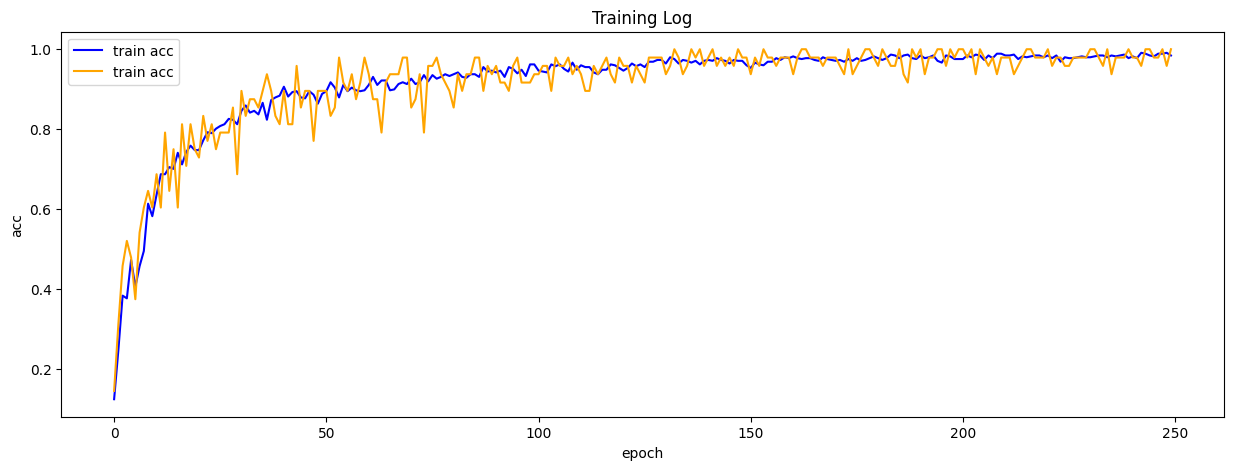

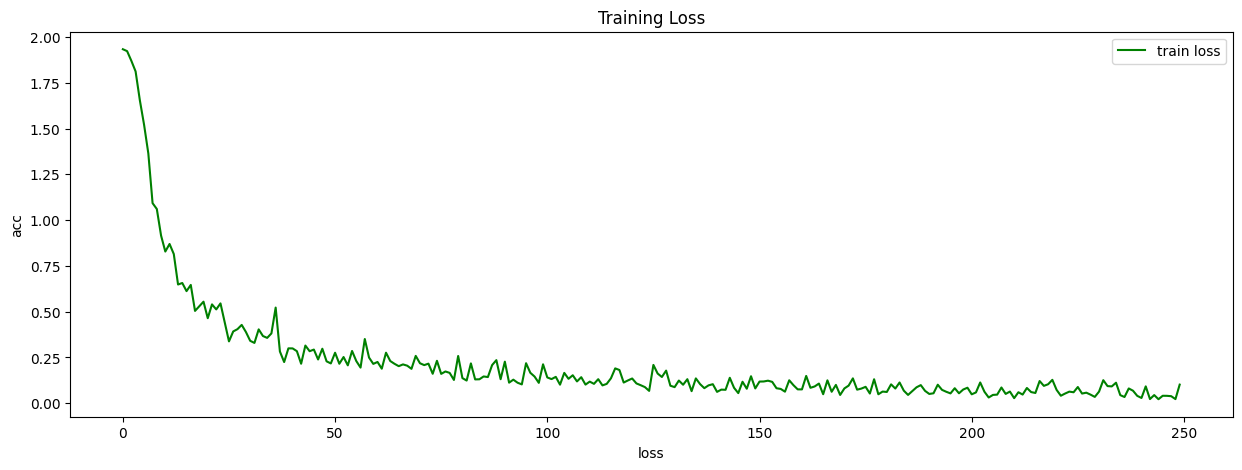

In [44]:
net = Network(7)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
net = train(net,train_loader)

In [45]:
tr_acc, tr_all_preds, tr_all_labels, tr_matrix = eval(net, train_loader)
print(f" Train acc = {tr_acc}")
te_acc, te_all_preds, te_all_labels, te_matrix = eval(net, test_loader)
print(f" Eval acc = {te_acc}")

 Train acc = 0.9919354838709677
 Eval acc = 0.9301007556675063


Training data F1 score =  0.9931504040031172
Testing data F1 score =  0.9297987951845179


[]

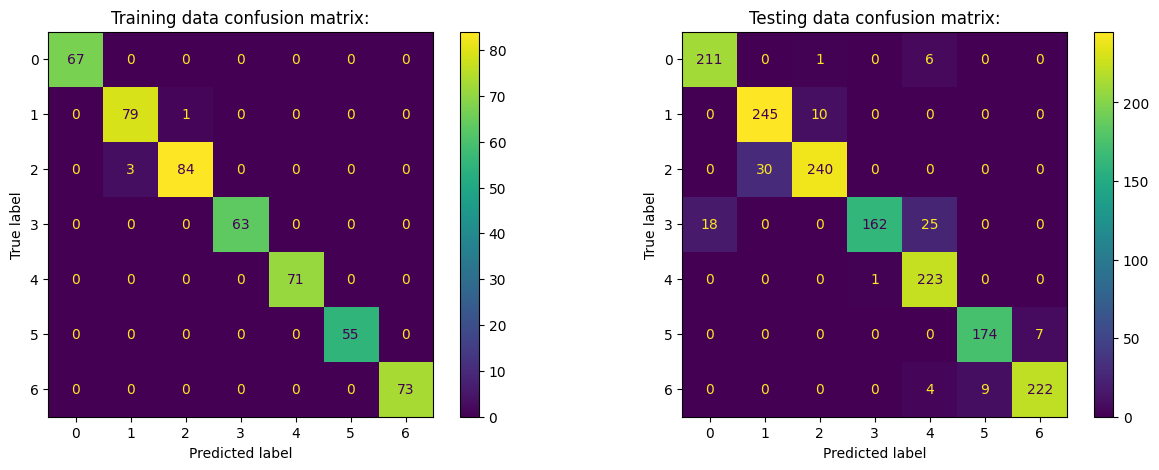

In [46]:
train_f1 = metrics.f1_score(tr_all_labels,tr_all_preds,average='macro')
test_f1 = metrics.f1_score(te_all_labels,te_all_preds,average='macro')
print("Training data F1 score = ", train_f1)
print("Testing data F1 score = ", test_f1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].title.set_text("Training data confusion matrix:")
ev_mat_disp = metrics.ConfusionMatrixDisplay(tr_matrix)
ev_mat_disp.plot(ax=ax[0])
ax[1].title.set_text("Testing data confusion matrix:")
ts_mat_disp = metrics.ConfusionMatrixDisplay(te_matrix)
ts_mat_disp.plot(ax=ax[1])
plt.plot()

## Discussion
F1 score is = 0.929
Best result I had ranged from F1 0.89 to 0.95
Sadly my network is overfitting.
As one can see the results aren't better than in task 5.2 attempt nr 2 (athough I havent hyperpyrametrized the neural network much)
This is prove that simple svm methods can be sometimes more usefull if the time of the training and developmenit is crutioual and they can give compariable results when the dataset is small